In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import os 
from model.SimCLR import SimCLR
from model.Train import Trainer
from model.Losses import NTXentLoss
from utils.DataLoaderSimCLR import DataLoaderSimCLR as DSC
from torch.utils.data import DataLoader, random_split
from utils.Similarity import Similarity as SMY
from utils.Plotter import Plotter as PL

In [37]:
torch.cuda.empty_cache()

In [38]:
SSH = os.getcwd() != 'c:\\Cours-Sorbonne\\M1\\Stage\\src'

In [39]:
path_rol_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed" 
path_rol_super_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_super_compressed" 
path_sim_rol_extracted_comp = "C:/Cours-Sorbonne/M1/Stage/src/data/similaires_rol_extracted_nn_compressed" 
path_filtered = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_compressed/json_filtered"
path_targets = "C:/Cours-Sorbonne/M1/Stage/src/data/rol_sim_rol_triplets/targets.npy"

if SSH:
    path_rol_comp = "../data/rol_super_compressed" 
    path_sim_rol_extracted_comp = "../data/sim_rol_super_compressed" 
    path_filtered = "../data/rol_super_compressed/json_filtered"
    path_targets = "../data/rol_sim_rol_couples/targets.npy"

## Params

In [40]:
epochs = 50
image_size = 256
batch_size = 32
learning_rate = 1e-3
train_ratio = 0.8
val_ratio = 0.2
temperature = 0.5

In [43]:
dataset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, 
    augment_halftone=False, 
    augment_test=False, use_only_rol=True, use_context=False, max_images=100
)

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

[INFO] Using ROL Dataset with 99 images
[INFO] Loaded exsisting targets


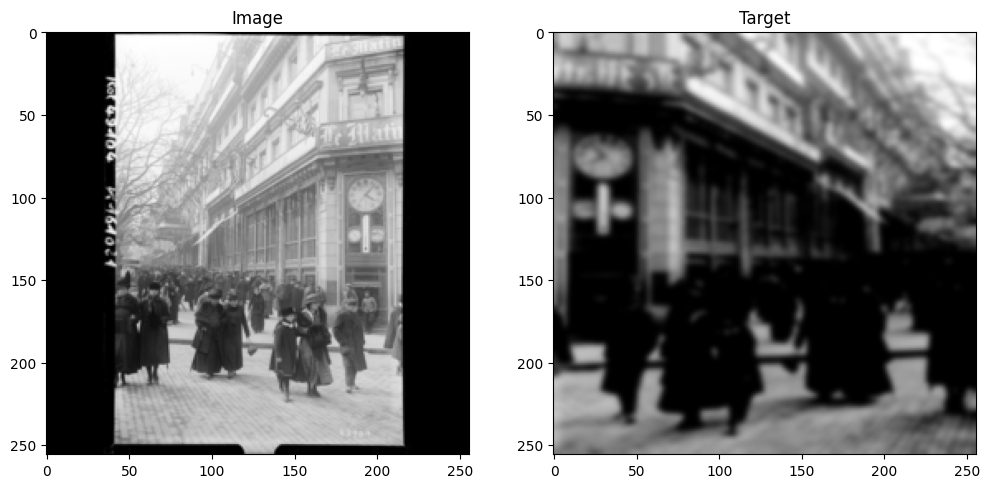

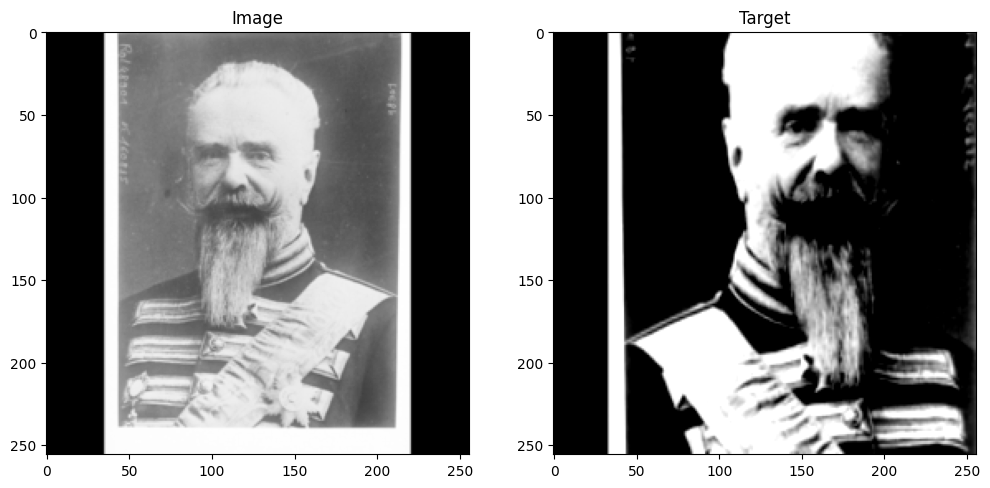

In [44]:
DSC.show_data(train_loader,use_context=False)
DSC.show_data(val_loader,use_context=False)

# Approche Supervisé

In [3]:
model = SimCLR(feature_size=128)
optimizer = torch.optim.AdamW
loss_fn = NTXentLoss(temperature=temperature)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


NameError: name 'temperature' is not defined

In [ ]:
trainer = Trainer()
trainer.set_model(model, "SimCLR-128") \
.set_optimizer(optimizer) \
.set_loss(loss_fn) 

model = trainer.fit(
    train_data=train_loader, validation_data=val_loader, learning_rate=learning_rate, 
    verbose=True, epochs=epochs, sim_clr=True, use_context=True
)

In [ ]:
trainer.save("model_simclr.pth","history_simclr.txt")

## Testing

In [91]:
testset = DSC(
    path_rol_comp, path_sim_rol_extracted_comp, path_filtered, 
    shape=(image_size, image_size), target_path=path_targets, augment_halftone=False,
    use_only_rol=False, augment_test=True, remove_bad_pairs=True, remove_to_enhance_files=True
)

[INFO] Loaded exsisting targets
[INFO] Before filtering : 1926 images
[INFO] After filtering : 1337 images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


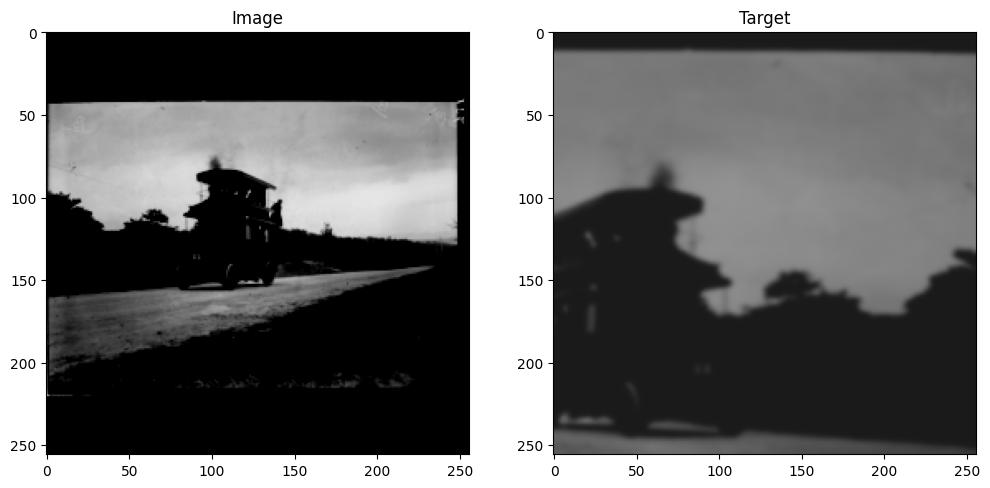

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


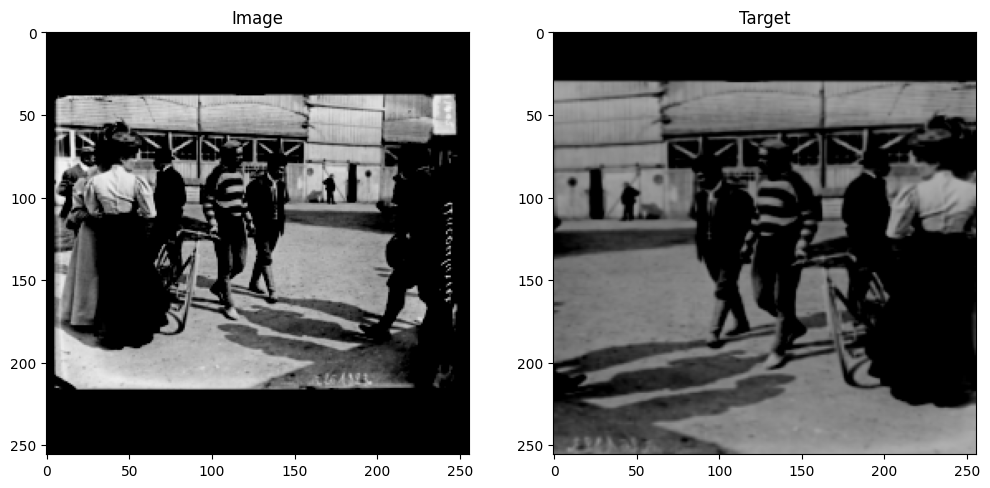

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


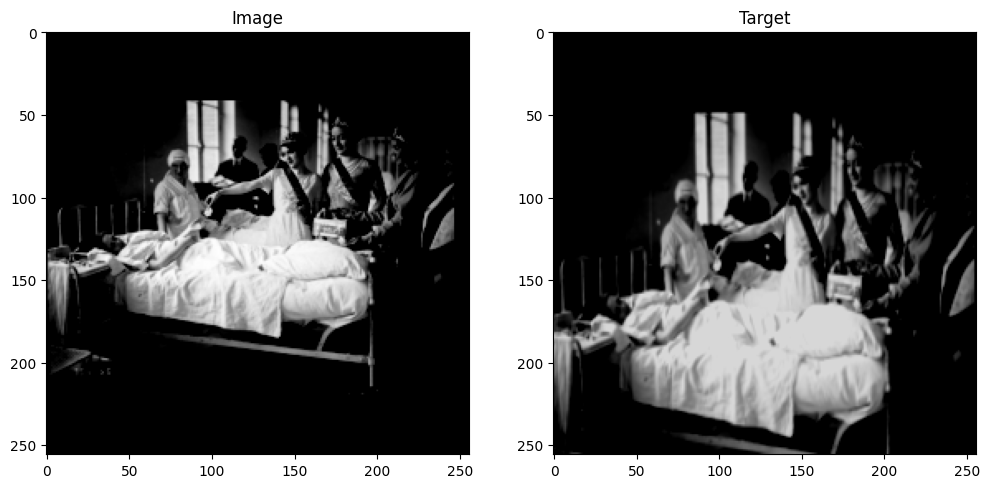

In [92]:
test_loader = DataLoader(testset, batch_size=8, shuffle=True)
DSC.show_data(test_loader, 3)

In [88]:
model = SimCLR(feature_size=128)
model_state = Trainer().get_model("./params/model/model_simclr.pth")
model.load_state_dict(model_state)
history = Trainer().get_history("./params/model/history_simclr.txt")

In [89]:
best_pairs, original_images, augmented_images = SMY.match_images_with_simCLR(model, test_loader=test_loader, use_context=False)

[INFO] Matching on cuda


100%|██████████| 168/168 [01:00<00:00,  2.79it/s]


[INFO] Accuracy : 0.8347045624532535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


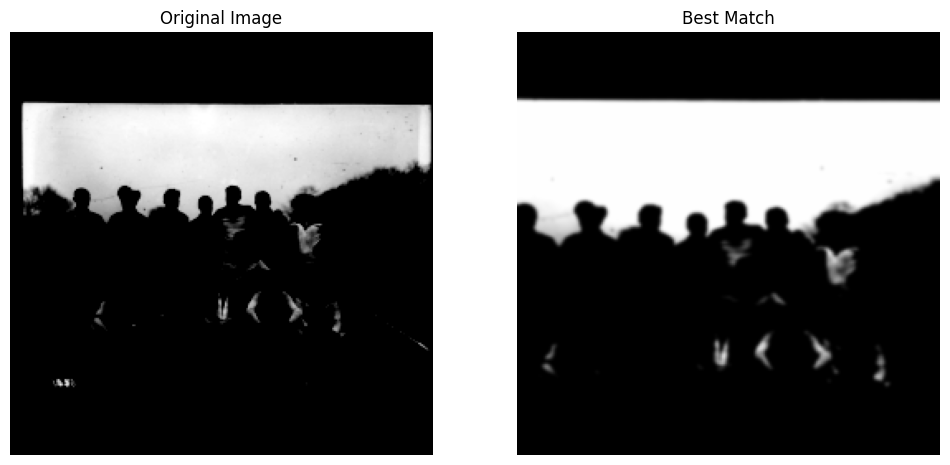

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


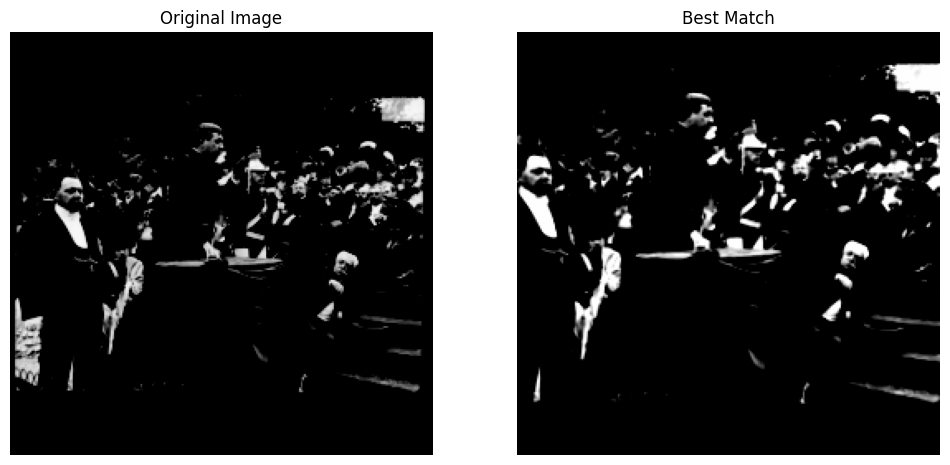

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


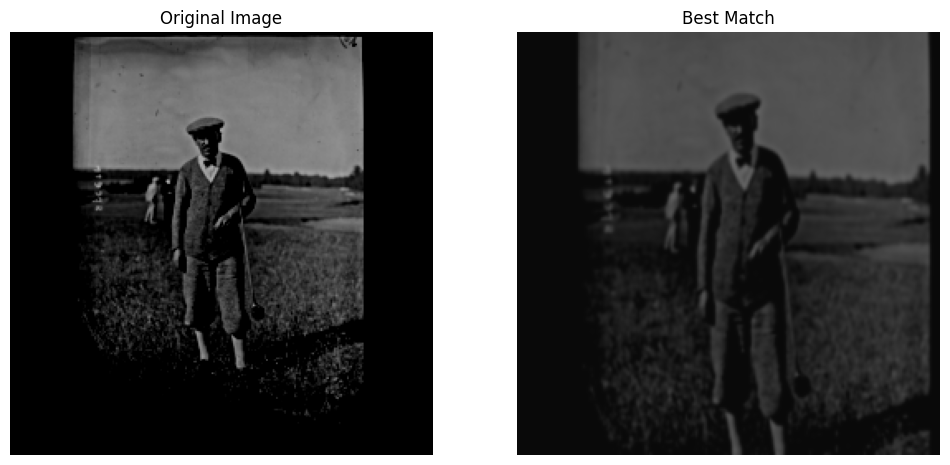

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


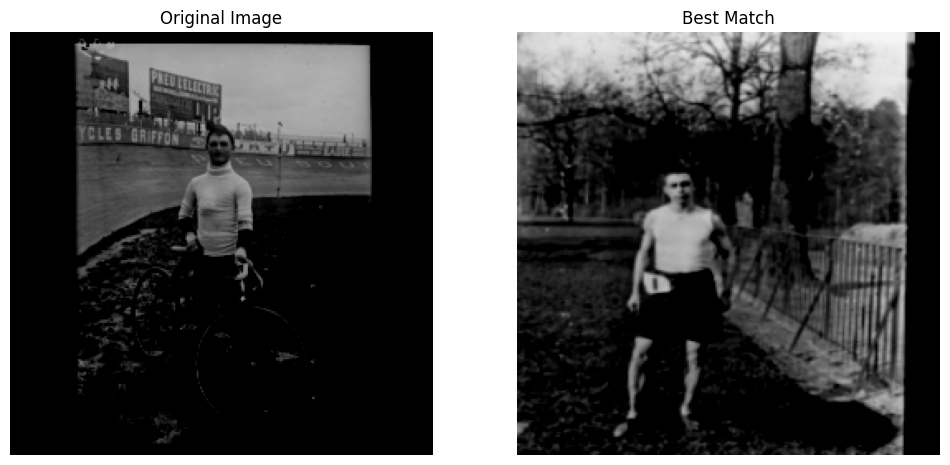

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


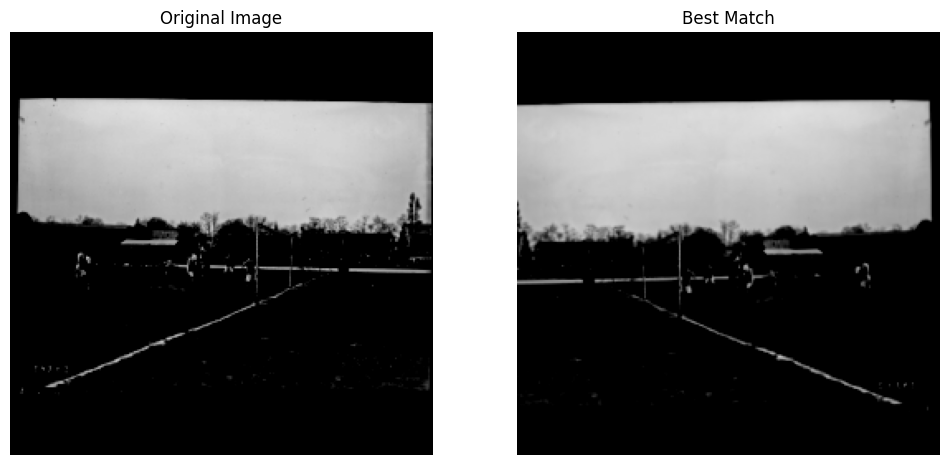

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


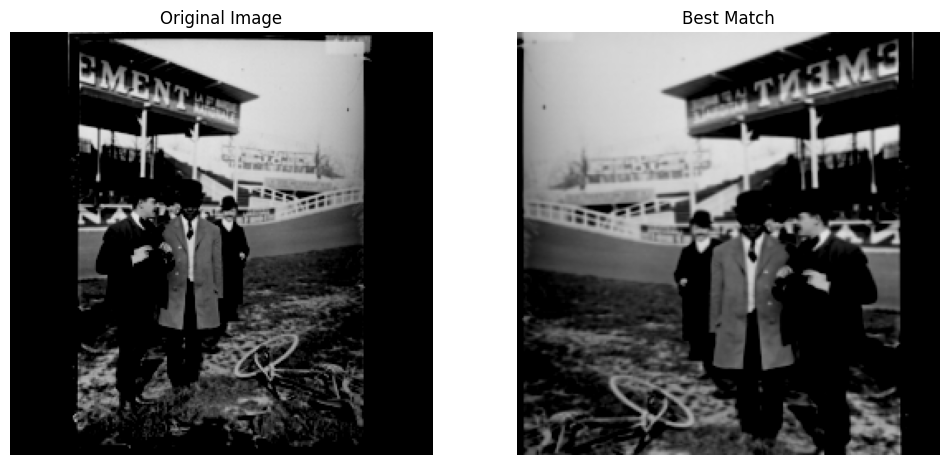

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


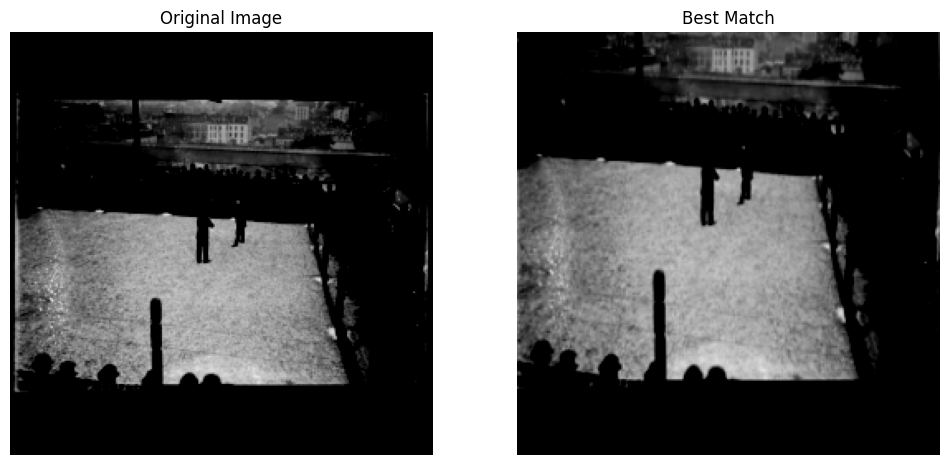

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


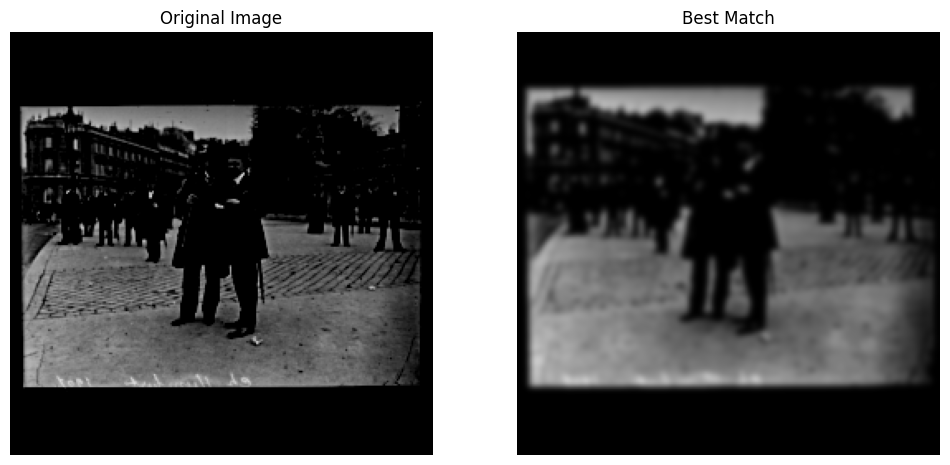

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


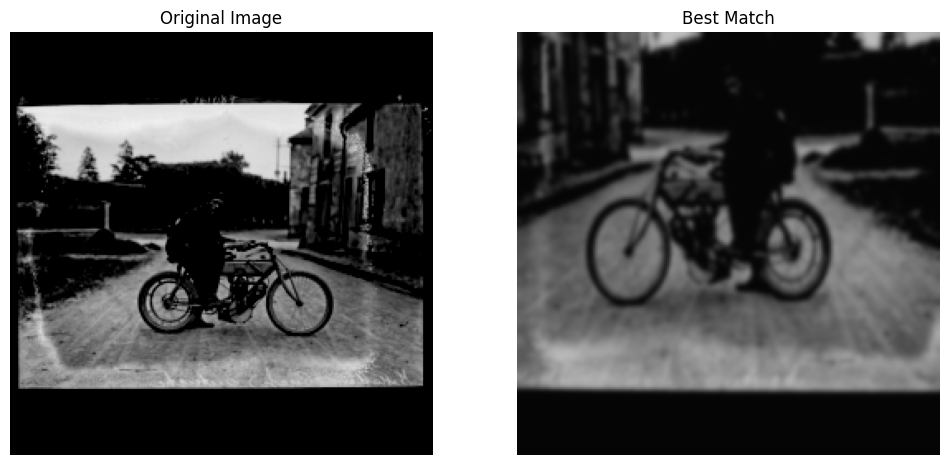

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


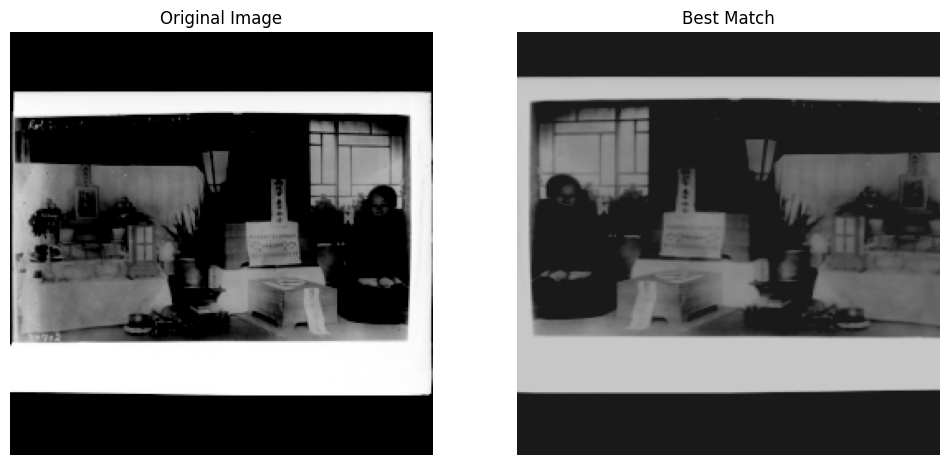

In [90]:
PL.plot_best_pairs(best_pairs, original_images, augmented_images, max_images=10)